In [103]:
#Import and set magics
import numpy as np
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader
import pydst
import statsmodels.api as stat
import statsmodels.formula.api as statf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import sympy as sm
import math
import random

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D



# Estimating income processes


Consider $N$ households indexed by $i$ who are in the labor market for $T$ periods indexed by $t \in ${1,2,...,T}$,

Their **wage income** is stochastic and given by,
 
$P_{i,t}$ = $\psi_{i,t}$ $P_{i,t-1}$

$\tilde{Y}_{i,t}$ = $xi_{i,t}$ $P_{i,t}$

$Y_{i,t}$ = \left\begin{array}{rcl}$
            \overline{\overline{0}+\text{if}\mu_{i,t}<\pi}
            \\tilde{Y}_{i,t} +\text{else}
            \end{array}\right.


   


$\psi_{i,t}$ ~ LogNormal(-0.5$\sigma_{\psi}^2$,$\sigma_{\psi})$

$\xi_{i,t}$ ~ LogNormal(-0.5$\sigma_{\xi}^2$,$\sigma_{\xi})$

$\mu_{i,t}$ ~ $Uniform(0,1)$


$P_{0} = 1$
   
where

$\sigma_{\psi}$ is the standard deviation of the *permanent* shocks, $\psi_{i,t}$

$\sigma_{\xi}$ is the standard deviation of the *transitory* shocks, $\xi_{i,t}$

$\pi$ is the risk of unemployment

The data you have access to is:


In [64]:
import numpy as np
dataY = np.load(r'C:\Users\musse\Documents\GitHub\projects-2020-zjr-hrv\projects-2020-zjr-hrv\dataY.npy')
T,N = dataY.shape
print(dataY)
print(dataY.shape)




[[0.83317569 0.72881172 0.         ... 1.16771806 0.93207083 0.86711803]
 [1.18542294 0.92826337 1.62913142 ... 1.13903869 0.94479246 0.78842682]
 [1.14813596 0.90542496 0.70634401 ... 1.49584791 1.08969956 0.        ]
 ...
 [0.73818651 0.59958039 0.56135238 ... 2.60075173 1.07070489 0.43010036]
 [1.14130879 0.85728537 0.54530761 ... 3.79294856 0.67764143 0.38720822]
 [0.64908127 0.85101393 0.59517395 ... 3.32800991 0.82400879 0.5814573 ]]
(20, 50000)


**Question 1:** Calculate income growth rates as log-changes

In [65]:
#Defining income growth rate by finding the first differences. Thereafter replacing the negative Y-values with .nan

logY = np.diff(np.log(dataY))
#diff_dataY = np.diff(dataY) 
  
# printing initial arrays 
print("Initial diff", logY) 
  
# code to replace all negative value with 0 
logY[logY<=0] = np.nan
  
# printing result 
print("New resulting diff: ", logY) 






Initial diff [[-0.13382911        -inf         inf ...  0.45991757 -0.22539794
  -0.0722337 ]
 [-0.2445394   0.56248678 -0.45247293 ...  0.10650339 -0.18697465
  -0.18092569]
 [-0.2374906  -0.24830202  0.49367077 ...  0.38133059 -0.31679118
         -inf]
 ...
 [-0.20796646 -0.06588123  0.6550227  ...  1.08826931 -0.88748332
  -0.9120539 ]
 [-0.2861601  -0.45242079  0.43603115 ...  1.35354726 -1.7222807
  -0.5596557 ]
 [ 0.27087056 -0.35757477  0.31896575 ...  1.52939372 -1.39594858
  -0.34864367]]
New resulting diff:  [[       nan        nan        inf ... 0.45991757        nan        nan]
 [       nan 0.56248678        nan ... 0.10650339        nan        nan]
 [       nan        nan 0.49367077 ... 0.38133059        nan        nan]
 ...
 [       nan        nan 0.6550227  ... 1.08826931        nan        nan]
 [       nan        nan 0.43603115 ... 1.35354726        nan        nan]
 [0.27087056        nan 0.31896575 ... 1.52939372        nan        nan]]


**Question 2:** Calculate the following 3 statistics from the data:

$s_{1}$: Share of observations with $Y_{i,t}$=0

$s_{2}$: Variance of income growth rate, Var($\Delta$ Log $Y_{i,t}$)

$s_{3}$: Covariance of income growth rates one period apart, Cov($\Delta$ Log $Y_{i,t}$,$\Delta$ Log $Y_{i,t-1}$ )

In [66]:
#First, we define moments to use in both question 2 and 3: 
def momments(Y):
    s_sim1 = np.count_nonzero(Y==0)/np.size(Y)
    Y[Y<0] = np.nan
    Ydiff = np.diff(np.log(Y))
    cov = pd.DataFrame(Ydiff).cov()

    s_sim2 = np.zeros(Ydiff.shape[1])
    for i in range(Ydiff.shape[1]):
        s_sim2[i] = cov.iloc[i,i]
    s_sim2 = np.mean(s_sim2)

    s_sim3 = np.zeros(Ydiff.shape[1]-1)
    for i in range(Ydiff.shape[1]-1):
        s_sim3[i] = cov.iloc[i,(i+1)]
    s_sim3 = np.mean(s_sim3)

    return s_sim1, s_sim2, s_sim3

The figures in question 2 are now calculated as follows:

In [67]:
#S1_data
s_data = [None]*3
#S2_data
s_data[0], s_data[1], s_data[2] = momments(dataY.T)
#S3_data
s_data

[0.049925, 0.054993983413371354, -0.022504802437365256]

Question 3: Simulate the income process using your own choice of $\sigma_{\psi}$, $\sigma_{\xi}$, $\pi$, T and N. Calculate the 3 same statistics. Compare with the data statistics

In [68]:

#Simulated figures
T = 50
N = 1000
pi = 0.3
s_psi = 0.23
s_xi = 0.4
P_0 = 1

#Defining simulation
def sim(s_psi,s_xi,pi,N,T):
    #Model
    Y = np.zeros((N,T))
    np.random.seed(1)
    for t in range(T):
        psi = np.random.lognormal(-0.5 * s_psi, s_psi, N)
        xi = np.random.lognormal(-0.5 * s_xi,s_xi, N)
        P = psi * P_0
        Y_tilde = xi * P
        mu = np.random.uniform(0,1,N)
        Y[(pi<mu),t] = Y_tilde[(pi<mu)]
    return Y

Y_sim = sim(s_psi,s_xi,pi,N,T)
#S1_sim
s_sim = [None]*3
#S2_sim
s_sim[0], s_sim[1], s_sim[2] = momments(Y_sim)
#S3_sim
s_sim



[0.29988, 0.425019139369132, -0.21104509754699205]

Comparison of the simulated data and the factual dataset

s1_sim =0.29988

s1_data = 0.049925

s2_sim = 0.425019139369132

s2_data = 0.054993983413371354

s3_sim = -0.21104509754699205

s3_data = -0.022504802437365256

Overall, the dataset has lower numbers than the simulated data.

**Question 4:** Solve the following minimization problem to estimate $\sigma_{\psi}$, $\sigma_{\xi}$ and $\pi$ 

$\sigma_{\psi}^*$, $\sigma_{\xi}^*$, $\pi^*$ = $arg_{\sigma_{\psi}>=0,\sigma_{\xi}>=0,\pi\in [0,1]}$               min $(s_{1}^{sim}-s_{1}^{data})^2$ + $(s_{2}^{sim}-s_{2}^{data})^2$ + $(s_{3}^{sim}-s_{3}^{data})^2$

where for each new guess of $\sigma_{\psi}$, $\sigma_{\xi}$ and $\pi$ you should be re-simulating the data with the same seed and re-calculate the 3 statistics

In [63]:
#Defining the objective function
def objective(s):

    Y = sim(s[0],s[1],s[2],N,T)
    s_sim1, s_sim2, s_sim3 = momments(Y)
    #obj =  (s_sim1 - s_data1)**2 + (s_sim2 - s_data2)**2 + (s_sim3 - s_data3)**2 
    obj =   (s_sim1 - s_data[0])**2 + (s_sim2 - s_data[1])**2 + (s_sim3 - s_data[2])**2 
    return obj


x0 = np.ones(3)/100

#Minimizing
res = optimize.minimize(objective,x0,method='L-BFGS-B',options={'eps':1e-4},bounds=((0,None),(0,None),(0,None),))
res

      fun: 1.6144875720339336e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.25305304e-05,  6.20294454e-06, -2.49368487e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 16
   status: 0
  success: True
        x: array([0.11493023, 0.11775912, 0.04956846])

# Wealth in the utility function

In the final period, t=T, the household solves the following problem:



$$
\begin{aligned}
v_{T}(a_{T-1})&= \max_{c_{T}}\frac{(c_{T}^{1-\rho})}{1-\rho} + \kappa \frac{(a_{T}+a\underline)^{1-\sigma}}{1-\sigma} \\
\text{s.t.} \\
a_{T} = (1+r)a_{T-1}+y-c_{T}
\end{aligned}
$$

where 

 * $a_t$ is end-of-period assets in period $t$
 * $c_t$ is consumption in period $t$
 * $\rho$ is the CRRA-coefficient for consumption utility
 * $\sigma$ is the CRRA-coefficient for wealth utility
 * $\underline{a}$ is an *additive* scaling factor for wealth utility
 * $\kappa$ is a *multiplicative* scaling factor for wealth utility
 * $r$ is the rate of return
 * $y$ is income
  
The optimal **consumption function** is denoted $c_t^{*}(a_{t-1})$

The optimal **savings function** is denoted $a_t^{*}(a_{t-1}) = (1+r)a_{t-1} + y - c_t^{*}(a_{t-1})$.
  

In [95]:
# a. parameters
rho = 2.0
sigma = 1.2
kappa = 0.6
a_ubar = 2.0
r = 0.04
y = 1.0
# b. grids
a_lag_vec = np.linspace(0,300,300)



**Question 1:** Find and plot the functions $v_{T}(a_{T-1})$, $c_T^{*}(a_{T-1})$, and $a_T^{*}(a_{T-1})$
 

In [121]:
#Definining the given utility function
def utility (c,y,r,rho,kappa,a_lag,a_ubar,sigma):
    return c**(1-rho)/(1-rho) + (kappa*(((1+r)*a_lag+y-c)+a_ubar)**(1-sigma))/(1-sigma)


In [97]:
#Defining the solution function for period T
def solve_period_T(rho,kappa,a_ubar,sigma,y):

    vT_grid = np.empty(a_lag_vec.size)
    cT_grid = np.empty(a_lag_vec.size) 
    aT_grid = np.empty(a_lag_vec.size) 

    # solve for a_lag in grid
    for i, a_lag in enumerate(a_lag_vec): 

    
        # Objective function
        obj = lambda c: -utility(c,y,r,rho,kappa,a_lag_vec[i],a_ubar,sigma)

        #Initial guess of consumption
        x0 = a_lag_vec[i]/10 + y
        #Optimization
        result = optimize.minimize(obj,[x0],method='L-BFGS-B')
        #Saving our results
        vT_grid[i] = -result.fun
        cT_grid[i] = result.x
        aT_grid[i] = (1+r)*a_lag_vec[i]+y-cT_grid[i]

    return vT_grid,cT_grid,aT_grid


In [99]:
v_grid =  [None]*(T+1)
c_grid = [None]*(T+1)
a_grid = [None]*(T+1)
v_interp_list =  [None]*(T+1)

In [100]:
#Solving the max problem in period T
v_grid[T],c_grid[T],a_grid[T] = solve_period_T(rho,kappa,a_ubar,sigma,y)


In [101]:
#Constructing interpolator
v_interp_list[T] = interpolate.RegularGridInterpolator([a_lag_vec],v_grid[T], bounds_error=False)

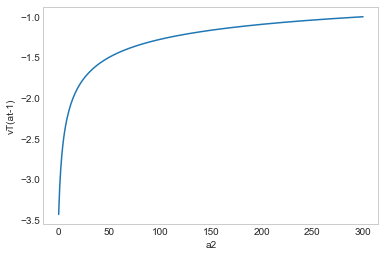

In [106]:
#Plotting vT

fig, ax = plt.subplots()
ax.plot(a_lag_vec,v_grid[T])

ax.set(xlabel='$[a_T]$', ylabel='$v_T[aT-1]$')
ax.grid()

fig.savefig("$v_T$")
plt.show()


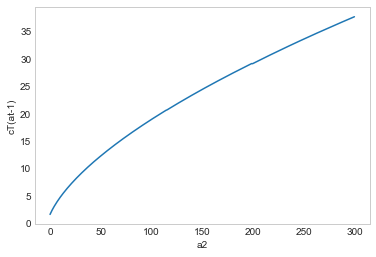

In [107]:
#Plotting cT

fig, ax = plt.subplots()
ax.plot(a_lag_vec,c_grid[T])

ax.set(xlabel='$[a_T]$', ylabel='$c^*_T[aT-1]$')
ax.grid()

fig.savefig("$c_T$")
plt.show()



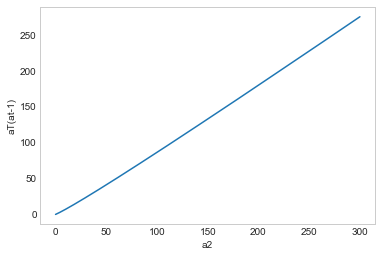

In [109]:
#Plotting aT

fig, ax = plt.subplots()
ax.plot(a_lag_vec,a_grid[T])

ax.set(xlabel='$a_[T-1]$', ylabel='$a_T^*(aT-1)$')
ax.grid()

fig.savefig("$a_T$")
plt.show()


**Question 2:** Find and plot $v_{T-1}(a_{T-2})$ and  $c_{T-1}^{*}(a_{T-2})$.


In all periods *before the last*, $t < T$, the household solves:
 
 

$v_{t}(a_{t-1})$ = $max_{c_{t}} \frac{c_t^{1-\rho}}{1-\rho} + \kappa \frac{(a_t+\underline{a})^{1-\sigma}}{1-\sigma} + \beta v_{t+1}(a_t)$

{s.t.} 
    $a_{t} = (1+r)a_{t-1} + y - c_{t}$

where $\beta$ is the discount factor for future utility.

In [122]:
beta = 0.97
T= 20

In [135]:
#solve function for period t
def solve_period_t(rho,kappa,a_ubar,sigma,y,t):

    vt_grid = np.empty(a_lag_vec.size)
    ct_grid = np.empty(a_lag_vec.size) 
    at_grid = np.empty(a_lag_vec.size) 

    #solve for each lag in grid
    for i, a_lag in enumerate(a_lag_vec): 

    
        #objective function
        obj = lambda c: -utility(c,y,r,rho,kappa,a_lag_vec[i],a_ubar,sigma) - beta*v_interp_list[t+1]([((1+r)*a_lag+y-c)])
        #Initial guess
        x0 = a_lag_vec[i]/10 + y
        #optimazation
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,None),))
        #saving results
        vt_grid[i] = -result.fun
        ct_grid[i] = result.x
        at_grid[i] = (1+r)*a_lag_vec[i]+y-ct_grid[i]

    return vt_grid,ct_grid,at_grid

In [136]:
#Creating a loop to calculate for both question 2 and 3
for i in range(T):
    
    t = T-i-1
    v_gridt,c_gridt,a_gridt = solve_period_t(rho,kappa,a_ubar,sigma,y,t)
    v_grid[t] = v_gridt
    c_grid[t] = c_gridt
    a_grid[t] = a_gridt
    v_interp_list[t] = interpolate.RegularGridInterpolator([a_lag_vec],v_grid[t], bounds_error=False, fill_value=None)


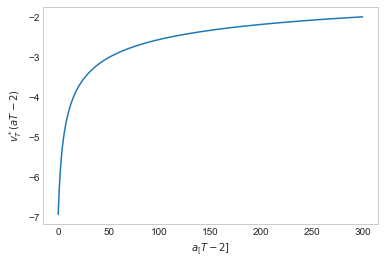

In [137]:
#Plotting vt
fig, ax = plt.subplots()
ax.plot(a_lag_vec,v_grid[19])

ax.set(xlabel='$a_[T-2]$', ylabel='$v_T^*(aT-2)$')
ax.grid()

fig.savefig("$v_[T-1]$")
plt.show()

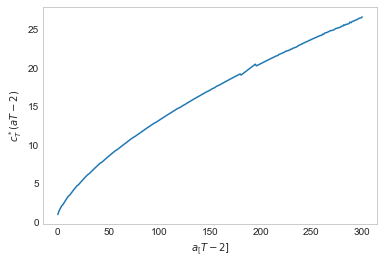

In [138]:
#Plotting c_t-1

fig, ax = plt.subplots()
ax.plot(a_lag_vec,c_grid[19])

ax.set(xlabel='$a_[T-2]$', ylabel='$c_T^*(aT-2)$')
ax.grid()

fig.savefig("$c_[T-1]$")
plt.show()

**Question 3:** Find $c_t^{*}(a_{t-1})$ for $t \in {0,1,...,T}$ and plot them in a single figure.


 


In [129]:
#for i in range(T):
    
    #t = T-i-1
    #v_gridt,c_gridt,a_gridt = solve_period_t(rho,kappa,a_ubar,sigma,y,t)
    #v_grid[t] = v_gridt
    #c_grid[t] = c_gridt
    #a_grid[t] = a_gridt
    #v_interp_list[t] = interpolate.RegularGridInterpolator([a_lag_vec],v_grid[t], bounds_error=False, fill_value=None)


No handles with labels found to put in legend.


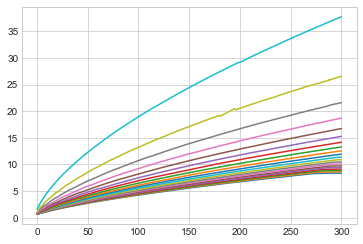

In [152]:
#Plotting c_t from 1 to T
plt.plot (a_lag_vec,c_grid[1])
plt.plot (a_lag_vec,c_grid[2])
plt.plot (a_lag_vec,c_grid[3])
plt.plot (a_lag_vec,c_grid[4])
plt.plot (a_lag_vec,c_grid[5])
plt.plot (a_lag_vec,c_grid[6])
plt.plot (a_lag_vec,c_grid[7])
plt.plot (a_lag_vec,c_grid[8])
plt.plot (a_lag_vec,c_grid[9])
plt.plot (a_lag_vec,c_grid[10])
plt.plot (a_lag_vec,c_grid[11])
plt.plot (a_lag_vec,c_grid[12])
plt.plot (a_lag_vec,c_grid[13])
plt.plot (a_lag_vec,c_grid[14])
plt.plot (a_lag_vec,c_grid[15])
plt.plot (a_lag_vec,c_grid[16])
plt.plot (a_lag_vec,c_grid[17])
plt.plot (a_lag_vec,c_grid[18])
plt.plot (a_lag_vec,c_grid[19])
plt.plot (a_lag_vec,c_grid[20])


plt.legend()


Define the saving rate as:

$s_{t}^* (a_{t-1})$ = $\frac{(a_{t}-a_{t-1}+y-c_{t}^*(a_{t-1}))-a_{t-1}}{y+ra_{t-1}}$


**Question 4:** Plot $s_0^{*}(a_{-1})$. Do the rich or the poor save the most?
   

In [153]:
s_0 = (r*a_lag_vec + y - c_grid[0])/(y+r*a_lag_vec)

Text(0.5, 1.0, 'Savingsrate')

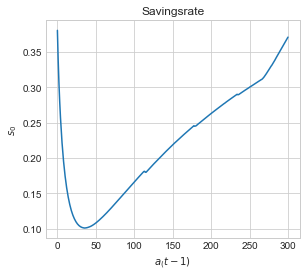

In [157]:
#Plot savingsrate
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(a_lag_vec,s_0)
ax.set_xlabel('$a_(t-1)$')
ax.set_ylabel('$s_0$')
ax.set_title('Savingsrate')

The saving rate have a u shape. If you are really poor then you save a lot and when you very rich then you save a lot too. Yet there is a interval where not either very rich or poor, save that much. So it is difficult to say because of the shape of the savingsrate.

**Question 5:** Can you change the parameter choices such that $s_0^{*}(a_{-1})$ is monotonically decreasing in $a_{-1}$?

In [192]:
#Changing the parameter r, to see if the saving rate is decreasing
r1=0
s_00 = (r1*a_lag_vec + y - c_grid[0])/(y+r1*a_lag_vec)

Text(0.5, 1.0, 'Savingsrate')

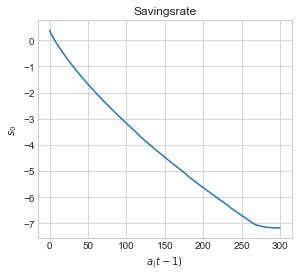

In [193]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(a_lag_vec,s_00)
ax.set_xlabel('$a_(t-1)$')
ax.set_ylabel('$s_0$')
ax.set_title('Savingsrate')

By setting the rate of return equal to 0, then we get a monotonically decreasing in a_t-1

# Refined grid search

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `grid_search()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a grid size $N$ and minimum and maximum values of $x_{1}$ and $x_{2}$ denoted $\overline{x_{1}}$>$\underline{x_{1}}$ and $\overline{x_{2}}$>$\underline{x_{2}}$
2. Calculate step sizes 

    $\Delta_{1}$ =($\overline{x_{1}}$-$\underline{x_{1}}$)/(N-1)
    
    $\Delta_{2}$ =($\overline{x_{2}}$-$\underline{x_{2}}$)/(N-1)
3. Find the grid point with the lowest function value solving 

    $j^{*}_{1}$, $j^{*}_{2}$ = $arg_{j_{1}\in{0,...,N-1}, j_{2}\in{0,...,N-1}}$  f( $\underline{x_{1}+j_{1}$\Delta_{1}$,$\underline{x_{2}+j_{2}$\Delta_{2}$)

    
    


1. Return 


**Question 1:** Implement the grid_search() algorithm to minimize the rosen function.


In [195]:
def rosen(x):
 return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2


In [215]:
# settings
x1_min = 0
x1_max = 5
x2_min = 0
x2_max = 4
N = 1000
#Implementing grid_search()
def grid_search(f,x1_min,x1_max,x2_min,x2_max,N):
    
    #calculate step sizes
    delta1=(x1_max-x1_min)/(N-1)
    delta2=(x2_max-x2_min)/(N-1)

    f_min = np.inf
    arg_x_min = None
    x = None

    #making a loop
    for i in range(N):
        for j in range(N):
            x = [x1_min+i*delta1,x2_min+j*delta2]
            f_val = f(x)
            if f_val < f_min:
                f_min = f_val
                arg_x_min = x
    



    return arg_x_min,f_min

# apply grid search
x,f = grid_search(rosen,x1_min,x1_max,x2_min,x2_max,N)
print('minimum found at' , x)
print('with the function value' ,f)

minimum found at [1.001001001001001, 1.001001001001001]
with the function value 3.0100230440752395e-06


**Question 2:** Implement the refined_grid_search() algorithm to minimize the rosen function

In [216]:
K = 10
def refined_grid_search(f,x1_min,x1_max,x2_min,x2_max,N,K):
    x = [None]*2
    k = 0
    #making a loop
    for i in range(K):
        if k > 0:
            x1_delta = 3*(x1_max-x1_min)/(N-1)
            x2_delta = 3*(x2_max-x2_min)/(N-1)
            x1_min = np.maximum(x1_min,x[0]-x1_delta)
            x2_min = np.maximum(x2_min,x[1]-x2_delta)

            x1_max = np.minimum(x1_max,x[0]+x1_delta)
            x2_max = np.minimum(x2_max,x[1]+x2_delta)

        x,f_max = grid_search(f,x1_min,x1_max,x2_min,x2_max,N)
        k = k + 1
        if k >= K: 
            
            return x, f_max 


# apply refined grid search
x,f_max = refined_grid_search(rosen,x1_min,x1_max,x2_min,x2_max,N,K)

In [219]:
np.minimum(1,2)

1

In [220]:
print('minimum found at', x)
print('at the function value', f_max)

minimum found at [1.0, 1.0]
at the function value 0.0
